In [ ]:
!pip install imbalanced-learn

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [69]:
df = pd.read_csv("singfake_metadata.csv")
original_columns = df.columns.tolist()
real = df[df['bonafide_or_spoof'] == 0].shape[0]
fake = df[df['bonafide_or_spoof'] == 1].shape[0]
print(f"Original Count:  Real: {real}, Fake: {fake}")
min_count = min(real, fake)

Original Count:  Real: 654, Fake: 631


In [71]:
category_columns = df.select_dtypes(include=['object']).columns.tolist()
print("Category columns found:", category_columns)
label_encoders = {}
for col in category_columns:
    lE = LabelEncoder()
    df[col] = lE.fit_transform(df[col])
    label_encoders[col] = lE
X = df.drop(columns=["bonafide_or_spoof"])
y = df["bonafide_or_spoof"]

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
balanced_df = pd.DataFrame(X_smote, columns=X.columns)
balanced_df["bonafide_or_spoof"] = y_smote

for col in category_columns:
    balanced_df[col] = balanced_df[col].astype(int)
    balanced_df[col] = label_encoders[col].inverse_transform(balanced_df[col])
for col in category_columns:
    balanced_df[col] = balanced_df[col].astype(str)

balanced_df.to_csv("singfake_eda.csv", index=False, encoding='utf-8')
new_real = balanced_df[balanced_df['bonafide_or_spoof'] == 0].shape[0]
new_fake = balanced_df[balanced_df['bonafide_or_spoof'] == 1].shape[0]
print(f"New count after balance: Real: {new_real}, Fake: {new_fake}")

Category columns found: ['set', 'language', 'singer', 'title', 'url']
New count after balance: Real: 654, Fake: 654


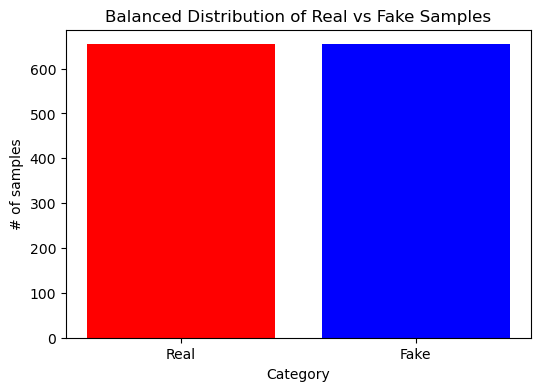

In [63]:
plt.figure(figsize=(6, 4))
plt.bar([0, 1], [new_fake, new_real], color=['red', 'blue'])
plt.xticks([0, 1], ['Real', 'Fake'])
plt.title('Balanced Distribution of Real vs Fake Samples')
plt.xlabel('Category')
plt.ylabel('# of samples')
plt.show()

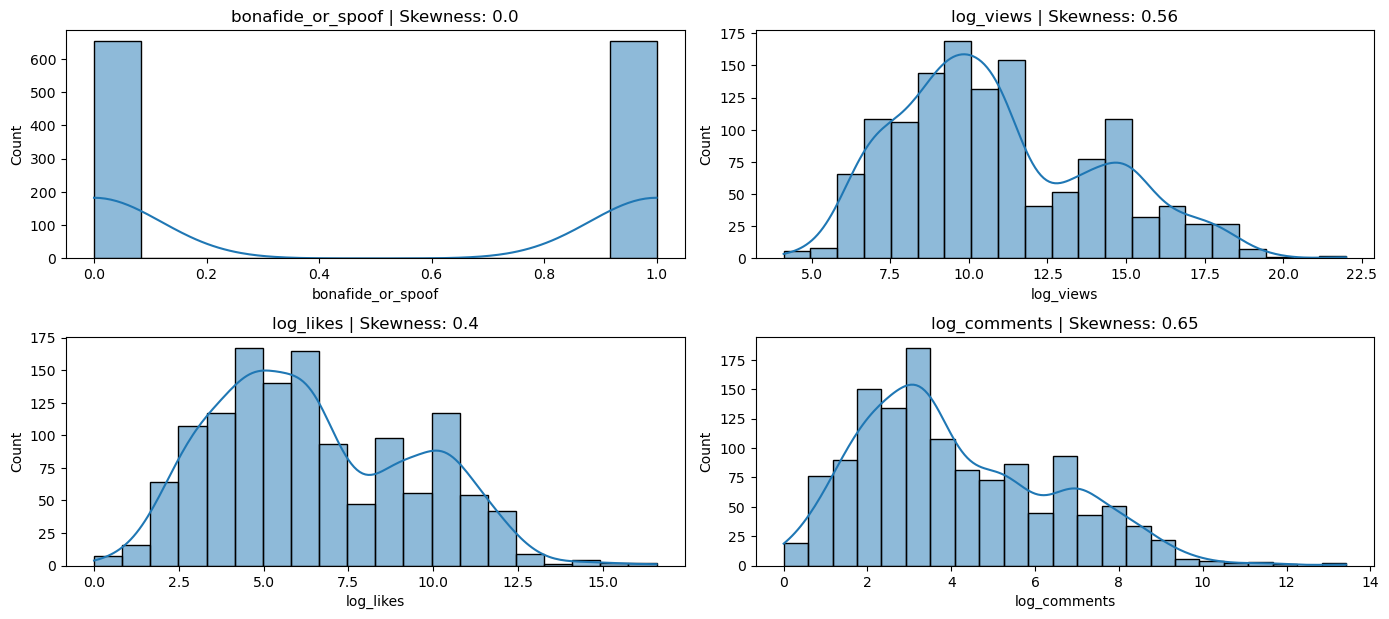

In [51]:
columns = balanced_df.select_dtypes(include=["int64", "float64"]).columns
skewed_features = ["views", "likes", "comments"]
for feature in skewed_features:
    balanced_df[f"log_{feature}"] = np.log1p(balanced_df[feature])
columns = [col for col in columns if col not in skewed_features] + [f"log_{col}" for col in skewed_features]
plt.figure(figsize=(14, len(columns) * 3))
for idx, feature in enumerate(columns, 1):
    plt.subplot(len(columns), 2, idx)
    sns.histplot(balanced_df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(balanced_df[feature].skew(), 2)}")
plt.tight_layout()
plt.show()

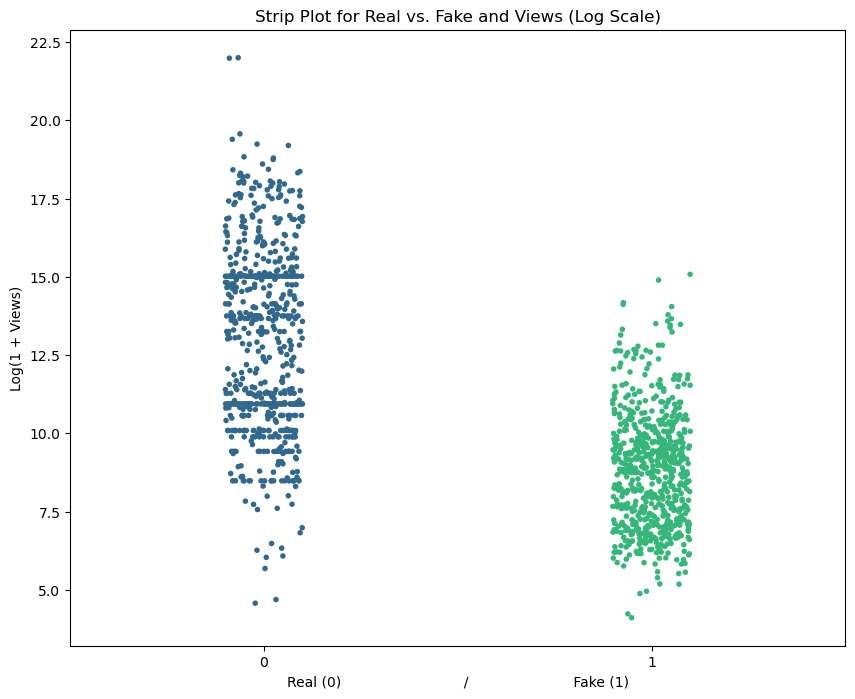

In [52]:
plt.figure(figsize=(10, 8))
sns.stripplot(x="bonafide_or_spoof", y="log_views", data=balanced_df, hue="bonafide_or_spoof", 
              palette='viridis', jitter=True, size=4, legend=False)
plt.title('Strip Plot for Real vs. Fake and Views (Log Scale)')
plt.xlabel('Real (0)                            /                        Fake (1)')
plt.ylabel('Log(1 + Views)')
plt.yscale("linear")
plt.show()